# Example to handle groups of varibles with known causal orders btw the groups for multiple datasets

## Import necessary packages

In [ ]:
import numpy as np
import pandas as pd
import graphviz
from sklearn.linear_model import LinearRegression, LogisticRegression
import lingam
from lingam.utils import make_dot, remove_effect, predict_adaptive_lasso

from IPython.display import display_svg, SVG

print([np.__version__, pd.__version__, graphviz.__version__, lingam.__version__])

['1.16.2', '0.24.2', '0.11.1', '1.4.0']


In [ ]:
# Output setting
np.set_printoptions(precision=3, suppress=True)
np.random.seed(0)

## Indicate which variable belong to which group

In [ ]:
# More than one Datasets to be analyzed
input_files = ['data1.csv', 'data3.csv']

# Indicate which variable belong to which group
set1_labels = ['x1_1', 'x1_2']
set2_labels = ['x2_1', 'x2_2', 'x2_3', 'x2_4', 'x2_5']
set3_labels = ['x3_1', 'x3_2', 'x3_3']
labels = set1_labels + set2_labels + set3_labels

## Load data

In [ ]:
X_list = [pd.read_csv(input_file) for input_file in input_files]

# Check if the third group includes a binary data
contain_bin_var_in_set3 = False
for i, X in enumerate(X_list):
    for set3_label in set3_labels:
        if len(np.unique(X[set3_label])) == 2:
            X[set3_label] = X[set3_label].astype(int)
            print(f'\x1b[31m変数セット3に2値の離散変数を含んでいます\x1b[0m：{[i]} {input_files[i]}')
            contain_bin_var_in_set3 = True
            break
        
X_list[0].head()

,x1_1,x1_2,x2_1,x2_2,x2_3,x2_4,x2_5,x3_1,x3_2,x3_3
0,0.102727,0.205501,1.026972,-0.271038,-0.124869,-0.157580,0.273743,0.179777,0.048608,0.376362
1,0.562784,-3.905674,0.232378,2.365468,0.235710,-2.103891,0.458637,-0.603726,-0.053263,2.230408
2,0.230076,-0.049555,0.162457,0.885359,-1.226624,-2.974060,0.730431,-0.061475,0.883855,1.862853
3,0.094054,0.540496,-0.644040,0.962975,-0.615114,-1.208096,0.031687,1.125484,-0.864481,-1.166307
4,-0.165689,-2.430977,0.152987,2.184269,-2.179047,-2.949728,-1.430591,-6.400437,-2.622068,-1.654538


## Compute the residual when each variable of the second group on all the variables of the first group

In [ ]:
X2_resid_list = []

for X in X_list:
    # Obtain the column numbers of the variables of the first group
    set1_indices = [X.columns.get_loc(label) for label in set1_labels]

    # Compute the residual when each variable of the second group on all the variables of the first group
    X_removed_set1 = remove_effect(X, set1_indices)

    # Creat the residual dataset for the second group by the residuals computed just above
    set2_indices = [X.columns.get_loc(label) for label in set2_labels]
    X2_resid_list.append(X_removed_set1[:, set2_indices])

## Perform LiNGAM on the residual dataset for the second group and draw the estimated causal graph

[0] data1.csv


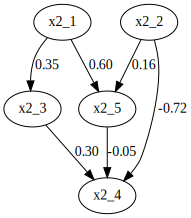

[1] data3.csv


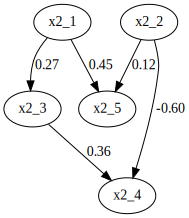

In [ ]:
# Perform LiNGAM
set2_model = lingam.MultiGroupDirectLiNGAM()
set2_model.fit(X2_resid_list)

# Draw the estimated causal graph
for i, _ in enumerate(X_list):
    print(f'{[i]} {input_files[i]}')
    g = make_dot(set2_model.adjacency_matrices_[i], labels=set2_labels)
    display_svg(SVG(g._repr_svg_()))

Regress each variable of the third group on all the variables of the first and second groups and compute the residuals

In [ ]:
X3_resid_list = []

if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variable\x1b[0m')
else:
    for X in X_list:
        # Obtain column numbers of the variables of the first and second groups
        set12_indices = [X.columns.get_loc(label) for label in set1_labels+set2_labels]

        # Regress each variable of the third group on all the variables of the first and second groups
        X_removed_set12 = remove_effect(X, set12_indices)

        # Create the residual dataset for the third group by the residuals computed just above
        set3_indices = [X.columns.get_loc(label) for label in set3_labels]
        X3_resid_list.append(X_removed_set12[:, set3_indices])

## Combine the causal grpahs for the second and third groups and draw it

[0] data1.csv


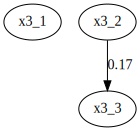

[1] data3.csv


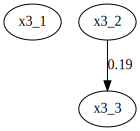

In [ ]:
if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variable\x1b[0m')
else:
    # Perform LiNGAM
    set3_model = lingam.MultiGroupDirectLiNGAM()
    set3_model.fit(X3_resid_list)
    
    # Draw the estimated graph
    for i, _ in enumerate(X_list):
        print(f'{[i]} {input_files[i]}')
        g = make_dot(set3_model.adjacency_matrices_[i], labels=set3_labels)
        display_svg(SVG(g._repr_svg_()))

## Compute causal effects from each variable of the second group to that of the third

[0] data1.csv


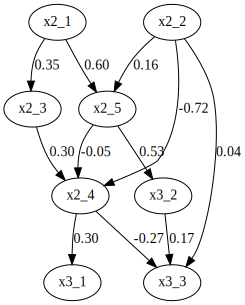

[1] data3.csv


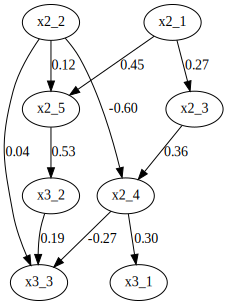

In [ ]:
if contain_bin_var_in_set3:
    print('\x1b[31mSkip because the third group includes a binary variable\x1b[0m')
else:
    for i, X in enumerate(X_list):
        # Adjucency matrix for the all the variables
        adj_matrix = np.zeros([X.shape[1], X.shape[1]])

        # Update the adjuncy matrix using the causal graph estimated for the second group
        set2_start_pos = len(set1_labels)
        set2_end_pos = set2_start_pos + len(set2_labels)
        adj_matrix[set2_start_pos:set2_end_pos, set2_start_pos:set2_end_pos] = set2_model.adjacency_matrices_[i]

        # Update the adjuncy matrix using the causal graph estimated for the third group
        set3_start_pos = len(set1_labels) + len(set2_labels)
        set3_end_pos = set3_start_pos + len(set3_labels)
        adj_matrix[set3_start_pos:set3_end_pos, set3_start_pos:set3_end_pos] = set3_model.adjacency_matrices_[i]

        # Compute the connection strengths from each variable of the second group to that of the third
        for j, idx in enumerate(set3_indices):

            # Obtain parents of each variable of the third group
            set3_parents = np.where(np.abs(set3_model.adjacency_matrices_[i][j]) > 0)[0]
            set3_parents = [X.columns.get_loc(set3_labels[idx]) for idx in set3_parents]

            # Create the set of explanatory variables
            predictors = []
            predictors.extend(set2_indices) # All the variables of the second group
            predictors.extend(set3_parents) # Parents in the third group

            # Pruning
            coefs = predict_adaptive_lasso(X_removed_set1, predictors, idx)
            adj_matrix[idx, set2_start_pos:set2_end_pos] = coefs[:len(set2_indices)]

        # Remove a part of the adjacency matrix corresponding the variables of the first group
        adj_matrix_set23 = adj_matrix[set2_start_pos:, set2_start_pos:]
        g = make_dot(adj_matrix_set23, labels=set2_labels+set3_labels)
        print(f'{[i]} {input_files[i]}')
        display_svg(SVG(g._repr_svg_()))

## Compute causal effects from each variable of the second group to that of the third

In [ ]:
for i, X in enumerate(X_list):
    print(f'{input_files[i]}')

    # Compute causal effects from each variable of the second group to that of the third
    for set3_label in set3_labels:
        for set2_label in set2_labels:

            # Create the variable index
            var2_index = X.columns.get_loc(set2_label)
            var3_index = X.columns.get_loc(set3_label)

            # Obtain parents of each variable of the second group
            parents = np.where(np.abs(set2_model.adjacency_matrices_[i][set2_labels.index(set2_label)]) > 0)[0]
            parents = [X.columns.get_loc(set2_labels[idx]) for idx in parents]

            # Create the set of explanatory variables
            predictors = [var2_index]
            predictors.extend(parents)
            predictors.extend(set1_indices)

            # If all the variables of the third group are continuous, peform linear regression
            # If they are binary, perform logistic regression
            if len(np.unique(X[set3_label])) != 2:
                lr = LinearRegression()
                lr.fit(X.iloc[:, predictors], X.iloc[:, var3_index])
                effect = lr.coef_[0]
            else:
                lr = LogisticRegression(solver='liblinear')
                lr.fit(X.iloc[:, predictors], X.iloc[:, var3_index])
                X_intervened = X.copy()
                X_intervened.iloc[:, var2_index] = X.iloc[:, var2_index].mean() # do(x=E(x))
                p1 = lr.predict_proba(X_intervened.iloc[:, predictors])
                X_intervened.iloc[:, var2_index] = X.iloc[:, var2_index].mean() + 1 # do(x=E(x)+1)
                p2 = lr.predict_proba(X_intervened.iloc[:, predictors])
                effect = p2[:, 1].mean() - p1[:, 1].mean() # The difference btw the two averages

            print(f'{set2_label} ---> {set3_label} : {effect:.3f}')

data1.csv
x2_1 ---> x3_1 : -0.004
x2_2 ---> x3_1 : -0.258
x2_3 ---> x3_1 : 0.085
x2_4 ---> x3_1 : 0.243
x2_5 ---> x3_1 : 0.000
x2_1 ---> x3_2 : 0.322
x2_2 ---> x3_2 : 0.112
x2_3 ---> x3_2 : -0.014
x2_4 ---> x3_2 : -0.045
x2_5 ---> x3_2 : 0.496
x2_1 ---> x3_3 : 0.054
x2_2 ---> x3_3 : 0.270
x2_3 ---> x3_3 : -0.085
x2_4 ---> x3_3 : -0.339
x2_5 ---> x3_3 : 0.121
data3.csv
x2_1 ---> x3_1 : 0.070
x2_2 ---> x3_1 : -0.160
x2_3 ---> x3_1 : 0.101
x2_4 ---> x3_1 : 0.396
x2_5 ---> x3_1 : 0.031
x2_1 ---> x3_2 : 0.255
x2_2 ---> x3_2 : 0.033
x2_3 ---> x3_2 : 0.033
x2_4 ---> x3_2 : 0.016
x2_5 ---> x3_2 : 0.588
x2_1 ---> x3_3 : 0.048
x2_2 ---> x3_3 : 0.258
x2_3 ---> x3_3 : -0.101
x2_4 ---> x3_3 : -0.295
x2_5 ---> x3_3 : 0.130
